In [1]:
import traceback
import yaml
import tweepy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import os
import tempfile
import imageio as iio
import requests

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('apikey.yml','r') as f:
    secret = yaml.safe_load(f.read())

consumer_key = secret['consumer_key']
consumer_secret = secret['consumer_secret_key']
access_token = secret['access_token']
access_token_secret = secret['access_token_secret']
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [3]:
def get_user_info(screen_name,res=None):
    user = api.get_user(screen_name=screen_name)
    if res == 'high':
        url = user.profile_image_url.replace('_normal.jpg','_400x400.jpg')
    else:
        url = user.profile_image_url
    profile_image = get_image(url)
    return user,profile_image

def get_image(profile_url):
    with tempfile.TemporaryDirectory() as tmpdirname:
        response = requests.get(profile_url)
        filepath = os.path.join(tmpdirname,'profile.jpg')
        if response.status_code == 200:
            with open(filepath,'wb') as f:
                f.write(response.content)
            image=iio.v3.imread(filepath)
            return image
        else:
            return None

In [4]:

# https://docs.tweepy.org/en/stable/api.html#tweepy.API.get_user
# API.get_user(*, user_id, screen_name, include_entities)

Dr. Jeff Ross (aka “Dr. Bear”) VailshireCap False Founder/CEO Vailshire Capital Management LLC & Vailshire Partners LP hedge fund (2013) | Investor | #RIA | Retired MD | MBA | @BitcoinMagazine Pro Fund Manager
(48, 48, 3)


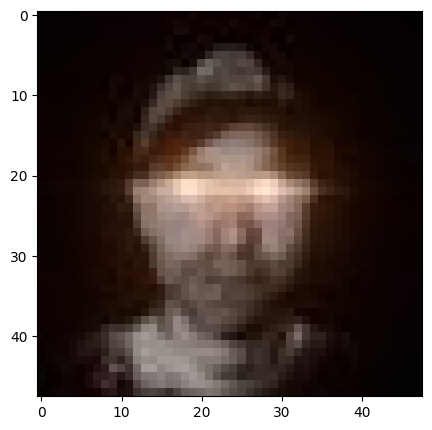

In [32]:
# @VailshireCap

screen_name = 'VailshireCap'
include_entities = True
user,profile_image = get_user_info(screen_name)

print(user.name,user.screen_name,user.verified,user.description)
plt.figure(figsize=(5,5))
_=plt.imshow(profile_image)
print(profile_image.shape)

In [33]:
# https://docs.tweepy.org/en/stable/api.html?highlight=search_users#tweepy.API.search_users
# API.search_users(q, *, page, count, include_entities)
# 
# page – Specifies the page of results to retrieve. Note: there are pagination limits.
# count – The number of results to try and retrieve per page.

In [37]:
# set reference image and corresponding query using `user.name`

reference_screen_name = 'VailshireCap'
user,reference_image = get_user_info(screen_name)
query = user.name

print(query)

Dr. Jeff Ross (aka “Dr. Bear”)


In [38]:

# find  page_count*items_per_page count that matches the query
# API limit is 1k.
fetch = []
page_num = 10
count_per_page = 100

try:
    for x in range(page_num):
        print(f'querying page {x}')
        tmp = api.search_users(query,count=count_per_page,page=x)
        fetch.extend(tmp)
        if len(tmp)<count_per_page:
            break
except:
    traceback.print_exc()
    
print(len(fetch))

querying page 0
6


In [39]:
print(fetch[0])

User(_api=<tweepy.api.API object at 0x7f23a11ea160>, _json={'id': 2285235781, 'id_str': '2285235781', 'name': 'Dr. Jeff Ross (aka “Dr. Bear”)', 'screen_name': 'VailshireCap', 'location': 'Colorado Springs, CO', 'description': 'Founder/CEO Vailshire Capital Management LLC & Vailshire Partners LP hedge fund (2013) | Investor | #RIA | Retired MD | MBA | @BitcoinMagazine Pro Fund Manager', 'url': 'https://t.co/FSDJsfp0pJ', 'entities': {'url': {'urls': [{'url': 'https://t.co/FSDJsfp0pJ', 'expanded_url': 'http://Vailshire.com', 'display_url': 'Vailshire.com', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 59827, 'friends_count': 3394, 'listed_count': 802, 'created_at': 'Fri Jan 10 15:05:39 +0000 2014', 'favourites_count': 62538, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 23382, 'lang': None, 'status': {'created_at': 'Sun Oct 30 18:19:33 +0000 2022', 'id': 1586784889357029377, 'id_str': '158678

In [40]:

import time
# try to find a match based on profile image
mylist = []
profile_cache = {}
user_cache = {}
for n,x in enumerate(fetch):
    try:
        user,profile_image = get_user_info(x.screen_name)
        # skip item if its reference
        if user.screen_name == reference_screen_name:
            continue
        # if http error skip
        if profile_image is None:
            profile_cache[user.screen_name]=None
            continue
        # compute only if shape matches
        if profile_image.shape == reference_image.shape:
            item = dict(screen_name=user.screen_name,mean_diff=np.mean(profile_image-reference_image))
            profile_cache[user.screen_name]=profile_image.copy()
            user_cache[user.screen_name]=x
        else:
            item = dict(screen_name=user.screen_name,mean_diff=np.nan)
            profile_cache[user.screen_name]=None
            user_cache[user.screen_name]=x
        mylist.append(item)
    except:
        traceback.print_exc()
        continue

df = pd.DataFrame(mylist)
print(df.shape)

(5, 2)


In [41]:
df = df.sort_values('mean_diff')

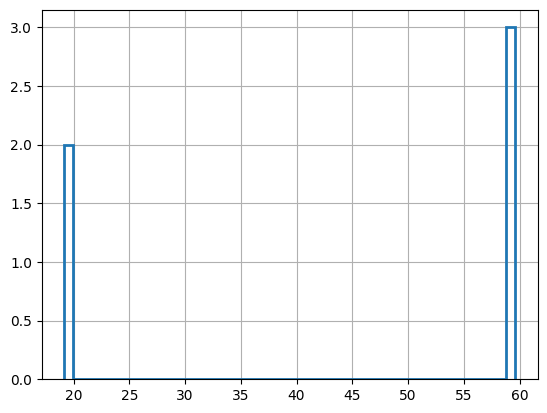

In [42]:
_=plt.hist(df.mean_diff,bins=50,histtype='step',linewidth=2)
plt.grid(True)

In [43]:
df

,screen_name,mean_diff
2,VailshireCapp_,19.171152
3,__VailshireCap_,19.171152
0,VailshrieCap,59.610966
1,VaiIshire_Cap,59.610966
4,VailshilreCap,59.610966


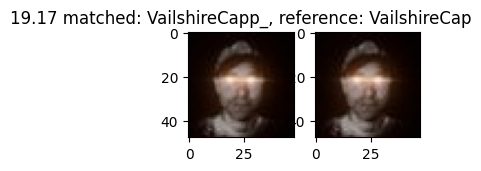

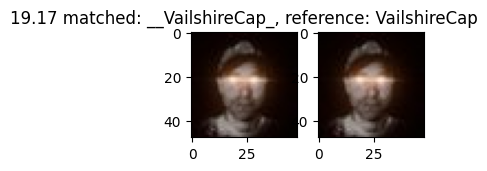

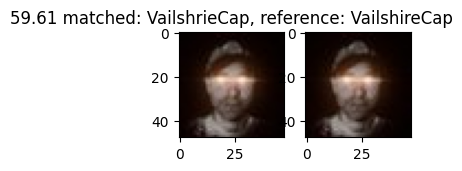

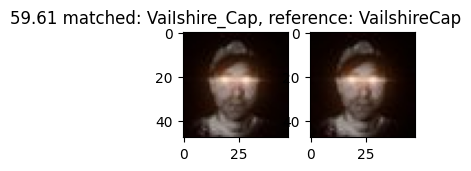

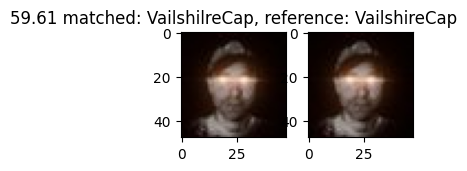

In [45]:
for n,row in df.iterrows():
    profile_image = profile_cache[row.screen_name]
    if profile_image is None:
        continue
    plt.figure(n,figsize=(3,3))
    plt.subplot(121)
    plt.title(f'{row.mean_diff:1.2f} matched: {row.screen_name}, reference: {reference_screen_name}')
    plt.imshow(profile_image)
    plt.subplot(122)
    plt.imshow(reference_image)

In [46]:
th = 100
likely_matched_df = df[df.mean_diff <= th].reset_index()
likely_matched_df

,index,screen_name,mean_diff
0,2,VailshireCapp_,19.171152
1,3,__VailshireCap_,19.171152
2,0,VailshrieCap,59.610966
3,1,VaiIshire_Cap,59.610966
4,4,VailshilreCap,59.610966


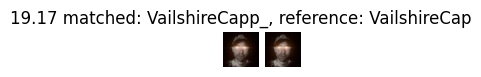

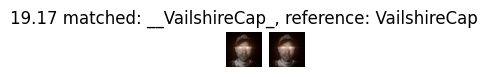

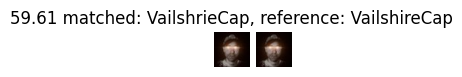

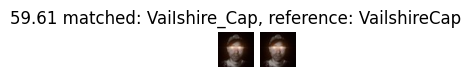

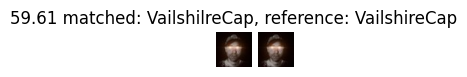

In [47]:
for n,row in likely_matched_df.iterrows():
    profile_image = profile_cache[row.screen_name]
    if profile_image is None:
        continue
    plt.figure(n,figsize=(1,1))
    #plt.tight_layout()
    plt.subplot(121)
    plt.title(f'{row.mean_diff:1.2f} matched: {row.screen_name}, reference: {reference_screen_name}')
    plt.imshow(profile_image)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(reference_image)
    plt.axis('off')
    

In [48]:
for n,row in likely_matched_df.iterrows():
    user = user_cache[row.screen_name]
    print(f'screen_name: {user.screen_name}\t,mean_diff:{row.mean_diff:1.2f}, name:{user.name[:-5]}')
    url = f'https://twitter.com/{user.screen_name}'
    print(url)

screen_name: VailshireCapp_	,mean_diff:19.17, name:Dr. Jeff Ross (aka “Dr. B
https://twitter.com/VailshireCapp_
screen_name: __VailshireCap_	,mean_diff:19.17, name:Dr. Jeff Ross (aka “Dr. B
https://twitter.com/__VailshireCap_
screen_name: VailshrieCap	,mean_diff:59.61, name:Dr. Jeff Ross (aka “Dr. B
https://twitter.com/VailshrieCap
screen_name: VaiIshire_Cap	,mean_diff:59.61, name:Dr. Jeff Ross (aka "Dr. B
https://twitter.com/VaiIshire_Cap
screen_name: VailshilreCap	,mean_diff:59.61, name:Dr. Jeff Ross (aka "Dr. B
https://twitter.com/VailshilreCap


In [49]:
for n,row in likely_matched_df.iterrows():
    user = user_cache[row.screen_name]
    url = f'https://twitter.com/{user.screen_name}'
    print(url)

https://twitter.com/VailshireCapp_
https://twitter.com/__VailshireCap_
https://twitter.com/VailshrieCap
https://twitter.com/VaiIshire_Cap
https://twitter.com/VailshilreCap
